# Astroimaging filter offset determination for best focus
G. Shaughnessy 9/18/2017

This is an attempt to measure both the focus offsets and drift with temperature for the LRGB filters I use for astro-imaging.  I'm using Astrodon LRGB E-series Gen2 filters with a TMB130SS, which is f/7 native and a focal reducer/flattener from Astronomics with a 0.8x magnification factor.  

The data was gathered on vdb142, the Elephant's Trunk Nebula, over one night.  Images were taken with Sequence Generator Pro, and autofocus was set to occur before each filter change.  The filter sequence was RGBRGBRGB... and managed to get 15-16 subs per filter.  I had forgotten to include Luminance for some reason, so halfway through the run, I added six Luminance exposures to help determine the filter offset from Luminance.

## Preliminaries

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from os import listdir
from os.path import isfile, join
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.rcParams['font.size']=14
import pandas as pd
import numpy as np
import seaborn as sns

In [17]:
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)

In [18]:
def getFocusParms(file,x):
    hdulist=fits.open(file)
    header=hdulist[0].header
    x.append([file,header['FILTER'],header['FOCTEMP'],header['FOCPOS'],header['TEMPERAT'],header['AIRMASS'],header['wgt'],header['DATE-LOC']])
    return x

In [19]:
paths=['2017-09-17/accepted/']
files=[path+f for path in paths for f in listdir(path) if isfile(join(path,f)) ]
print 'Number of total fits files: ',len(files)

Number of total fits files:  58


In [20]:
x=[]
for f in files:
    x=getFocusParms(f,x)
df=pd.DataFrame(x,columns=('file','Filter','Focuser Temperature','Focuser Position','Air Temperature','Airmass','FWHM','date'))    

## Determine the critical focus zone for this setup

CFZ is determined by the relation 
$$CFZ =  4.88 \cdot {\cal F}^2 \cdot \lambda$$
where ${\cal F}$ is the focal ratio, 5.6 in this case, and $\lambda$ is the wavelength of light, taken to be green or $\lambda=500nm$

The focus motor I'm using is the HSM30 from Starlight Instruments, and has a resolution of 24300 steps per inch.  

In [21]:
stepsPerInch=24300
micronsPerInch=25.4e3
micronsPerStep = micronsPerInch / stepsPerInch
print 'Microns per step = ', micronsPerStep

focalRatio=7*0.8
lam=500
CFZ=4.88*focalRatio**2*lam*1e-3
print 'Critical Focus zone (microns) = ',CFZ
print 'Critical Focus zone (steps) = ',CFZ*micronsPerStep

Microns per step =  1.04526748971
Critical Focus zone (microns) =  76.5184
Critical Focus zone (steps) =  79.9821958848


Drop first two samples of RGB filters as scope was still cooling down from taking outside.

In [22]:
R=df[df.Filter=='R'].sort_values(by='date').iloc[2:]
G=df[df.Filter=='G'].sort_values(by='date').iloc[2:]
B=df[df.Filter=='B'].sort_values(by='date').iloc[2:]
L=df[df.Filter=='L'].sort_values(by='date')

---

Check scatter of focuser temperature vs. FWHM of stars.  The luminance values are much lower since they're binned at 4x4 at 10s/sub instead of 1x1 at 300s/sub for the RGB set.  The addition of L in this sequence was an afterthought and I wanted to get a good RGB imaging set.  There does not appear to be any bias in the FWHM with temperature after tossing the first two images of the RGB set. 

---

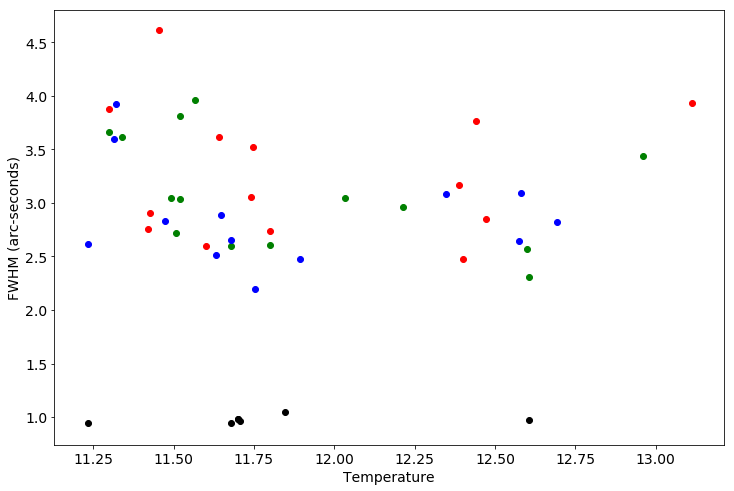

In [23]:
plt.scatter(R['Focuser Temperature'],R['FWHM'],color='r')
plt.scatter(G['Focuser Temperature'],G['FWHM'],color='g')
plt.scatter(B['Focuser Temperature'],B['FWHM'],color='b')
plt.scatter(L['Focuser Temperature'],L['FWHM'],color='k')
plt.xlabel('Temperature')
plt.ylabel('FWHM (arc-seconds)')

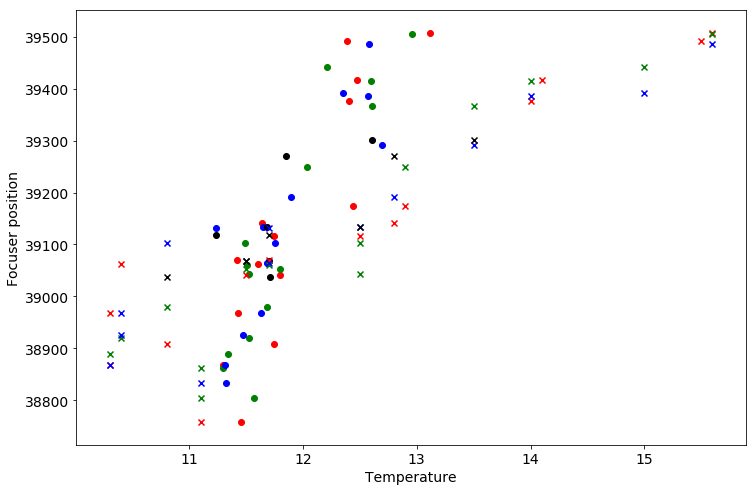

In [24]:
plt.figure()
plt.scatter(R['Focuser Temperature'],R['Focuser Position'],color='r')
plt.scatter(G['Focuser Temperature'],G['Focuser Position'],color='g')
plt.scatter(B['Focuser Temperature'],B['Focuser Position'],color='b')
plt.scatter(L['Focuser Temperature'],L['Focuser Position'],color='k')

plt.scatter(R['Air Temperature'],R['Focuser Position'],color='r',marker='x')
plt.scatter(G['Air Temperature'],G['Focuser Position'],color='g',marker='x')
plt.scatter(B['Air Temperature'],B['Focuser Position'],color='b',marker='x')
plt.scatter(L['Air Temperature'],L['Focuser Position'],color='k',marker='x')

plt.xlabel('Temperature')
plt.ylabel('Focuser position')

As final validation, check that the FWHM from each image as measured in the subframe selector tool in Pixinsight does not have a dependence on the focuser temperature.  This is to be expected since a focusing run is done on each filter before each subframe exposure.  

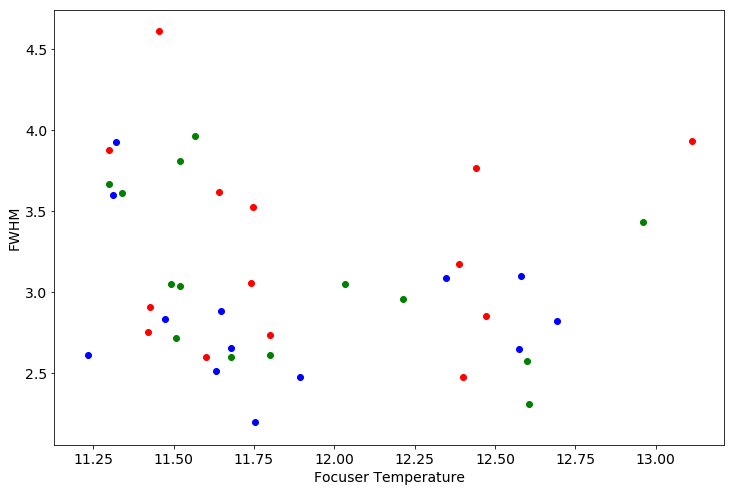

In [25]:
plt.figure()
plt.scatter(R['Focuser Temperature'],R['FWHM'],color='r')
plt.scatter(G['Focuser Temperature'],G['FWHM'],color='g')
plt.scatter(B['Focuser Temperature'],B['FWHM'],color='b')
plt.xlabel('Focuser Temperature')
plt.ylabel('FWHM')

# Fit with linear model

In [26]:
from sklearn import linear_model

Cycle through LRGB image set and perform fit.  Display the pearson's $r^2$ and the fit parameters.  The slope relates to the focus change with temperature and the intercept could viewed as a form of focus offset.  However, the focus offsets we should use should be based on a central temperature to avoid extrapolation.  Here, I use T=11.8 C

Offsets with respect to the Luminance filter are quite small, with the largest departure of 57 steps being within the range of the CFZ of my setup.  It appears these filters are indeed parfocal as advertised by Astrodon.  The slope is also similar among the RGB set, which is something to expect since the only thing changing is the filter in each of these data.  Thermal expansion and displacement of the focus spot should not be dependent on the filter used, and that's verified here.  

The Luminance set has a slope that is quite a bit off, probably due to the lower number of samples being used.  

In [27]:
for X in [L,R,G,B]:

    x=X['Focuser Temperature'].values.reshape(len(X),1)
    y=X['Focuser Position'].values.reshape(len(X),1)
    lm=linear_model.LinearRegression()
    model=lm.fit(x,y)

    r2=lm.score(x,y)
    m=lm.coef_[0][0]
    b=lm.intercept_[0]
    
    print ''
    filterName = X.Filter.iloc[0]
    print 'Filter = ',filterName
    print 'r^2 = ', r2
    print 'Slope = ', m
    print 'Intercept = ', b
    T=11.8
    filtPosition=m*T+b
    print 'Predicted = ',filtPosition
    
    if filterName == 'L':
        refPosition=m*T+b
    else:
        print 'Offset = ',filtPosition-refPosition
        
    


Filter =  L
r^2 =  0.460873064937
Slope =  170.120875408
Intercept =  37138.5091908
Predicted =  39145.9355206

Filter =  R
r^2 =  0.755359562881
Slope =  377.477623045
Intercept =  34634.6346863
Predicted =  39088.8706383
Offset =  -57.0648823239

Filter =  G
r^2 =  0.829978404787
Slope =  400.674311724
Intercept =  34366.2121322
Predicted =  39094.1690105
Offset =  -51.7665101041

Filter =  B
r^2 =  0.766312373334
Slope =  350.87002041
Intercept =  34976.2226965
Predicted =  39116.4889373
Offset =  -29.4465833029


# Display fits

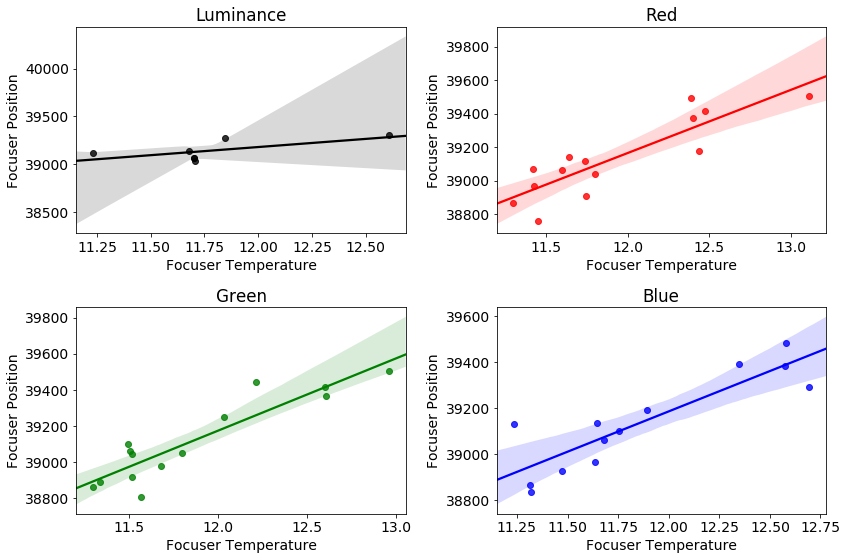

In [28]:
plt.figure()
plt.subplot(2,2,1)
sns.regplot(x='Focuser Temperature',y='Focuser Position',data=L,color='k')
plt.title('Luminance')
plt.subplot(2,2,2)
sns.regplot(x='Focuser Temperature',y='Focuser Position',data=R,color='r')
plt.title('Red')
plt.subplot(2,2,3)
sns.regplot(x='Focuser Temperature',y='Focuser Position',data=G,color='g')
plt.title('Green')
plt.subplot(2,2,4)
sns.regplot(x='Focuser Temperature',y='Focuser Position',data=B,color='b')
plt.title('Blue')
plt.tight_layout()
